In [28]:
import os
import time
import scipy.io as sio
import numpy as np

from my_funcs.plot_functions import t1_t2_pixel_reader

from my_funcs.cest_functions import bruker_dataset_creator
from my_funcs.cest_functions import dicom_data_arranger

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable


## scan data ##

In [29]:
# Root stats:
general_fn = os.path.abspath(os.curdir)
current_dir = os.getcwd()  # Get the current directory
parent_dir = os.path.dirname(current_dir)  # Navigate up one directory level

dict_name = 'mouse_larger_k'  # 'mouse_40', 'mouse_pickle', 'mouse_t_range', 'mouse_k_8500', 'mouse_larger_k'
net_name = 'mouse_larger_k_noise_01'  # ['mouse_40_noise_01', 'mouse_40_noise_005', 'mouse_40_noise_001'], ['mouse_20_noise_01', 'mouse_20_noise_005'], ['mouse_t_range_noise_01'], ['mouse_k_8500_noise_01'], ['mouse_larger_k_noise_01']
glu_noise = '01'

# Dict choice:
mt_dict_fn = os.path.join(parent_dir, 'data', 'exp', 'MT_pickle', 'MT52', 'dict.pkl') 
glu_dict_fn = os.path.join(parent_dir, 'data', 'exp', dict_name, '107a', 'dict.pkl')

# NN choice:
mt_nn_fn = os.path.join(current_dir, 'mouse_nns', 'mt_nns', f'mt_noise_01.pt') # mt nn directory
glu_nn_fn = os.path.join(current_dir, 'mouse_nns', 'glu_nns', f'{dict_name}', f'{net_name}.pt')  # nn directory # 'checkpoint_107a.pt'


# Subject data:
txt_file_name = 'labarchive_notes.txt'
save_name = 'mouse_mt_107'
fp_prtcl_names = ['107a']  # to be looped later with all options # 107a , 51_glu
f_const = 3 / 110000

subject_dicts = [
    {'scan_name': '24_04_04_glu_mouse_37deg',
     'sub_name': '1_mouse1_left',
     'month': 'apr',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [1, 8],  # up, right 
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
    {'scan_name': '24_04_04_glu_mouse_37deg',
     'sub_name': '2_mouse2_right',
     'month': 'apr',
     'center': [25, 14],
     'voxel_origin': [16, 11],
     't_shift': [0, 0],  # up, right 
     'save_name': save_name,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
        {'scan_name': '24_04_04_glu_mouse_37deg',
     'sub_name': '3_mouse3_two_ears',
     'month': 'apr',
     'center': [30, 19],
     'voxel_origin': [21, 14],
     't_shift': [0, 0],  # up, right 
     'save_name': save_name,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
     #    {'scan_name': '24_01_28_glu_mouse_37deg',
     # 'sub_name': '1_or_dino_mouse2_right_ear_middle_pierce',
     # 'month': 'jan',
     # 'center': [0, 0],
     # 'voxel_origin': [0, 0],
     # 'save_name': save_name,
     # 'temp': 37,
     # 'z_b1s': [0.7, 2],
     # 'z_b1s_names': ['0p7uT', '2uT']
     # },
 ]


## choose scan ##

In [36]:
fp_prtcl_name = fp_prtcl_names[0]
subject_i = 1

subject_dict = subject_dicts[subject_i]
phantom_choice = subject_i+1
glu_mouse_fn = os.path.join(parent_dir, 'data', 'scans', subject_dict['scan_name'], subject_dict['sub_name'])

glu_107a_fn, glu_mouse_mrf_files_fn, bruker_dataset_107a = bruker_dataset_creator(glu_mouse_fn, txt_file_name, '107a')


## mask ##

In [37]:
highres_fn, _, bruker_dataset_highres = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'T2_MSME_high')


In [38]:
def contour_finder(cur_mask):
    contour = measure.find_contours(image=cur_mask, level=0.5)[0]
    shift = 0.5
    contour[:, 1] += shift
    contour[:, 0] += shift
    
    # Find and add additional points to improve the contour plot
    points = []
    for idx0 in range(len(contour)):
        pos0 = contour[idx0]
        idx1 = idx0 + 1
        if len(contour) > idx1:
            pos1 = contour[idx1]
            y1, x1 = tuple(pos1)
            y0, x0 = tuple(pos0)
            if y1 - y0 and x1 - x0:
                point = np.array([y0, x1])
                if y0 % 1:
                    point = np.array([y1, x0])
                points.append((idx0, point))
    points.reverse()
    for idx0, point in points:
        contour = np.insert(contour, idx0 + 1, point, axis=0)
    
    # Deshift the contour before returning
    contour[:, 1] -= shift
    contour[:, 0] -= shift
        
    return contour


In [39]:
import plotly.express as px
highres_data = bruker_dataset_highres.data
highres_data = dicom_data_arranger(bruker_dataset_highres, highres_fn).astype(np.float)

index = 3 # Image index 4/5, 3, 3 (choose?)
fig = px.imshow(highres_data[index, :,:])  # Image index 4/5, 3, 3 (choose?)
fig.show()


In [26]:
from skimage.morphology import binary_erosion, binary_dilation
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
import cv2

highres_slice = highres_data[index, :,:] # 4/5, ,3
# Normalize the array to the range [0, 255]
normalized_slice = cv2.normalize(highres_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# Convert to 8-bit single-channel
highres_slice_8bit = np.uint8(normalized_slice)
highres_slice_8bit = cv2.GaussianBlur(highres_slice_8bit, (3, 3), 0)

brain_mask = np.zeros_like(highres_slice_8bit)

# _, thresh = cv2.threshold(highres_slice_16bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # Lower the threshold by multiplying it with a factor (e.g., 0.8)
# lowered_thresh = thresh * 0.8

binary = highres_slice_8bit > 35  # 30, 37, 35

# Define the structure element for erosion
structure = np.ones((8, 8), dtype=bool)  # Adjust the width of the structure as needed

# Perform binary erosion
eroded_image = binary_erosion(binary, structure)

label_image = label(eroded_image)
fig = px.imshow(label_image)
fig.show()
# Find the brain region
for region in regionprops(label_image):
    # print(region.area)
    # print(region.area_filled)
    # print(region.axis_minor_length / region.axis_major_length)
    if 5000 < region.area_filled < 9000:
        coords = region.coords
        rs, cs = coords[:, 0], coords[:, 1]
        brain_mask[rs, cs] = 1

# Define the structure element for erosion
structure = np.ones((8, 8), dtype=bool)  # Adjust the width of the structure as needed

# Perform binary erosion
diluted_mask = binary_dilation(brain_mask, structure).astype(np.uint8)
blurred_image = cv2.GaussianBlur(diluted_mask, (5, 5), 0)  # Adjust kernel size as needed
smoothed_mask = np.where(blurred_image > 0.5, 1, 0).astype(np.uint8)

# Resize the binary array to lower resolution (times 4)
downsampled_mask = cv2.resize(smoothed_mask.astype(np.uint8) * 255, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_NEAREST)
# Threshold the downsampled array to convert it back to a binary array
downsampled_mask = np.where(downsampled_mask > 127, 1, 0)

contour_mask = contour_finder(downsampled_mask)
fig = px.imshow(highres_slice_8bit)
fig.add_trace(go.Scatter(x=contour_mask[:, 1]*4, y=contour_mask[:, 0]*4, line=dict(color="red", width=1.5)), row=1, col=1)

fig.show()  


In [27]:
mask_path = os.path.join(os.path.dirname(os.path.dirname(glu_mouse_mrf_files_fn)), 'ds_mask.npy')
np.save(mask_path, downsampled_mask)


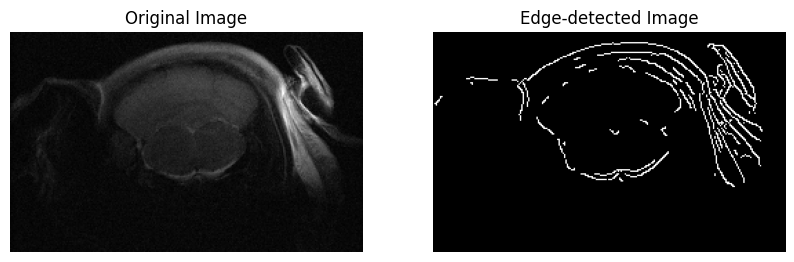

In [288]:
# from skimage.morphology import binary_erosion, binary_dilation
# from skimage import measure
# from skimage.measure import label, regionprops, regionprops_table
# import cv2
# 
# highres_slice = highres_data[3, :,:] # 4/5, ,3
# # Normalize the array to the range [0, 255]
# normalized_slice = cv2.normalize(highres_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# # Convert to 8-bit single-channel
# highres_slice_8bit = np.uint8(normalized_slice)
# 
# # Apply Gaussian blur to the image to reduce noise
# blurred_image = cv2.GaussianBlur(highres_slice_8bit, (5, 5), 0)
# 
# # Use Canny edge detection
# edges = cv2.Canny(blurred_image, 60, 70)  # Adjust thresholds as needed
# 
# # Plot original and edge-detected images
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(highres_slice_8bit, cmap='gray')
# plt.title('Original Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(edges, cmap='gray')
# plt.title('Edge-detected Image')
# plt.axis('off')
# 
# plt.show()
# 
